In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample 
from sklearn.metrics import confusion_matrix, classification_report

from cf_matrix import make_confusion_matrix

from IPython.display import display
%matplotlib inline

In [2]:
predictors = pd.read_csv("predictors.csv")
outcomes = pd.read_csv("outcomes.csv")

del predictors['DataExtractDt']
del outcomes['DataExtractDt']

#inner join 
df_org = predictors.merge(outcomes)

#The following patients have an unknown race_id - let's mark them NAN for now
display(df_org.loc[df_org['race_id']==0])
df_org.loc[df_org['race_id']==0, 'race_id'] = np.NaN

##Remap to ensure values range is consistent (0,1,2) across the columns
df_org['HR_HER2_STATUS'].replace({'HRposHER2neg':0,  'HER2pos':1,  'TripleNeg':2}, inplace=True)
df_org['HR_HER2_CATEGORY'].replace({1:0, 2:1, 3:2}, inplace=True)

#TODO: Remap PCR so that (No Surgery=Null=-1, 0 = NO PCR, 1 = PCR)  

#To use shorter names for attributes where needed
short_names ={'ERpos':'ER+',
       'PgRpos':'Pg+', 
       'HR Pos':'HR+', 
       'Her2MostPos':'HR2M+', 
       'HR_HER2_CATEGORY':'HR2C',
       'HR_HER2_STATUS':'HR2S', 
       'BilateralCa':'BCa', 
       'Laterality':'Lt'}

#Let's have a peek at the data
display(df_org)
display(df_org.describe())

,SUBJECTID,age,race_id,ERpos,PgRpos,HR Pos,Her2MostPos,HR_HER2_CATEGORY,HR_HER2_STATUS,BilateralCa,...,MRI LD Baseline,MRI LD 1-3dAC,MRI LD InterReg,MRI LD PreSurg,sstat,survDtD2 (tx),RFS,rfs_ind,PCR,RCBClass
64,1070,36.78,0,1.0,0.0,1.0,0.0,1.0,HRposHER2neg,0,...,56.0,50.0,21.0,19.0,7,1596,1596,0,1.0,0.0
96,1106,50.41,0,1.0,1.0,1.0,0.0,1.0,HRposHER2neg,0,...,60.0,56.0,56.0,41.0,8,1176,677,1,0.0,2.0


,SUBJECTID,age,race_id,ERpos,PgRpos,HR Pos,Her2MostPos,HR_HER2_CATEGORY,HR_HER2_STATUS,BilateralCa,...,MRI LD Baseline,MRI LD 1-3dAC,MRI LD InterReg,MRI LD PreSurg,sstat,survDtD2 (tx),RFS,rfs_ind,PCR,RCBClass
0,1001,38.73,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,...,88.0,78.0,30.0,14.0,8,1264,751,1,0.0,2.0
1,1002,37.79,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0,...,29.0,26.0,66.0,16.0,8,1155,1043,1,0.0,3.0
2,1003,49.83,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0,...,50.0,64.0,54.0,46.0,7,2387,2387,0,0.0,3.0
3,1004,48.28,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0,...,91.0,90.0,99.0,43.0,7,2436,2436,0,0.0,NaN
4,1005,45.80,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0,...,98.0,109.0,60.0,42.0,7,2220,2520,0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,1235,64.06,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,...,52.0,50.0,28.0,0.0,7,1026,1026,0,1.0,0.0
217,1236,38.61,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0,...,51.0,52.0,35.0,23.0,8,832,510,1,0.0,3.0
218,1237,46.46,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,...,60.0,60.0,37.0,36.0,7,1031,1031,0,0.0,2.0
219,1238,59.05,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0,...,48.0,NaN,NaN,NaN,7,1248,1248,0,0.0,NaN


,SUBJECTID,age,race_id,ERpos,PgRpos,HR Pos,Her2MostPos,HR_HER2_CATEGORY,HR_HER2_STATUS,BilateralCa,...,MRI LD Baseline,MRI LD 1-3dAC,MRI LD InterReg,MRI LD PreSurg,sstat,survDtD2 (tx),RFS,rfs_ind,PCR,RCBClass
count,221.000000,221.000000,219.000000,219.000000,219.000000,219.000000,216.000000,216.000000,216.000000,221.000000,...,219.000000,210.000000,202.000000,208.000000,221.000000,221.000000,221.000000,221.000000,215.000000,201.000000
mean,1121.411765,48.250679,1.972603,0.570776,0.474886,0.598174,0.310185,0.800926,0.800926,0.018100,...,69.041096,61.204762,45.930693,29.865385,7.226244,1403.859729,1312.556561,0.285068,0.269767,1.557214
std,69.534933,8.896377,4.721528,0.496099,0.500513,0.491390,0.463644,0.808213,0.808213,0.133614,...,30.948954,29.437485,29.875282,28.712655,0.470434,520.398277,580.983447,0.452472,0.444875,1.103612
min,1001.000000,26.690000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19.000000,9.000000,0.000000,0.000000,7.000000,185.000000,179.000000,0.000000,0.000000,0.000000
25%,1061.000000,42.080000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,47.000000,38.000000,22.000000,4.000000,7.000000,1126.000000,929.000000,0.000000,0.000000,0.000000
50%,1122.000000,49.100000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,68.000000,60.000000,42.500000,24.000000,7.000000,1427.000000,1349.000000,0.000000,0.000000,2.000000
75%,1181.000000,54.190000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,88.000000,79.750000,61.750000,45.250000,7.000000,1784.000000,1725.000000,1.000000,1.000000,2.000000
max,1239.000000,68.820000,50.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,184.000000,156.000000,141.000000,129.000000,9.000000,2468.000000,2520.000000,1.000000,1.000000,3.000000


Data has  221  rows of which  94 rows (approx. 42 %) have at least one missing value. 


,RCBClass,MRI LD InterReg,MRI LD PreSurg,MRI LD 1-3dAC,PCR,Her2MostPos,HR_HER2_CATEGORY,HR_HER2_STATUS,race_id,ERpos,PgRpos,HR Pos,MRI LD Baseline,survDtD2 (tx),rfs_ind,RFS,sstat,age,BilateralCa,Laterality
0,20,19,13,11,6,5,5,5,2,2,2,2,2,0,0,0,0,0,0,0


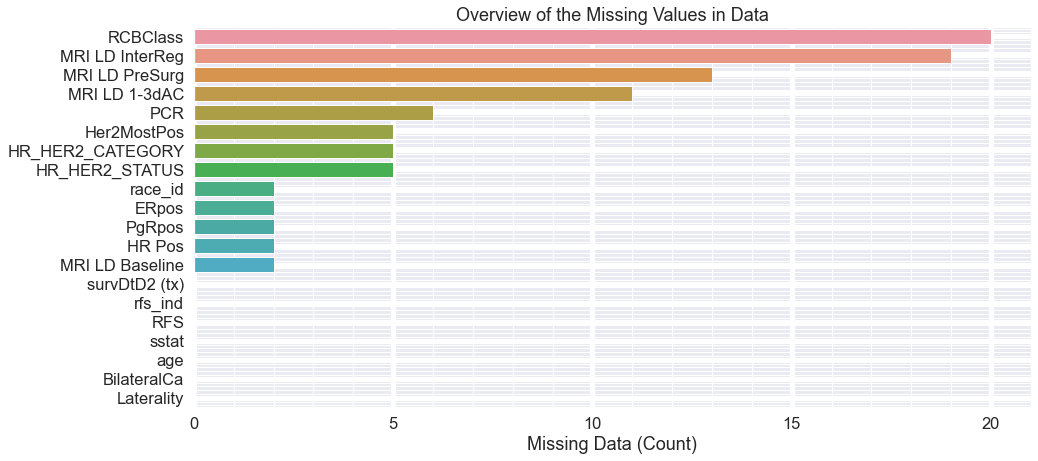

In [3]:
missing_values = df_org.isnull().sum().sort_values(ascending=False)
del missing_values['SUBJECTID']

ind = missing_values.index.to_list()
vals = missing_values[ind]

print('Data has ', df_org.shape[0] , ' rows of which ', missing_values.values.sum(), 'rows (approx.', 
      int(100*(missing_values.values.sum()/df_org.shape[0])), '%) have at least one missing value. ')

display(pd.DataFrame(missing_values).T)

#Plot missing values
#plt.rcParams['figure.dpi'] = 72
sns.set_context("poster")
sns.set(rc={'figure.figsize':(15,7)}, font_scale=1.5) 


g=sns.barplot(y=ind, x=vals)
g.set_xticks(np.arange(0,21,5));
g.set(xlabel="Missing Data (Count)", title='Overview of the Missing Values in Data')

g.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
g.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
g.grid(b=True, which='major', color='w', linewidth=5.0)
g.grid(b=True, which='minor', color='w', linewidth=1)

,race,counts
0,Caucasian,125
1,African American,31
2,Asian,8
3,Native Hawaiian /\n Pacific Islander,1
4,Multiple race,1


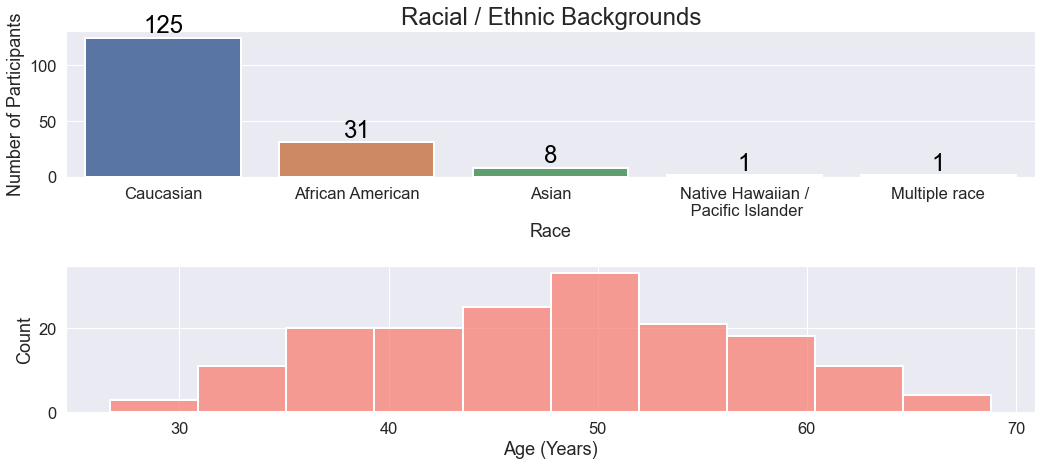

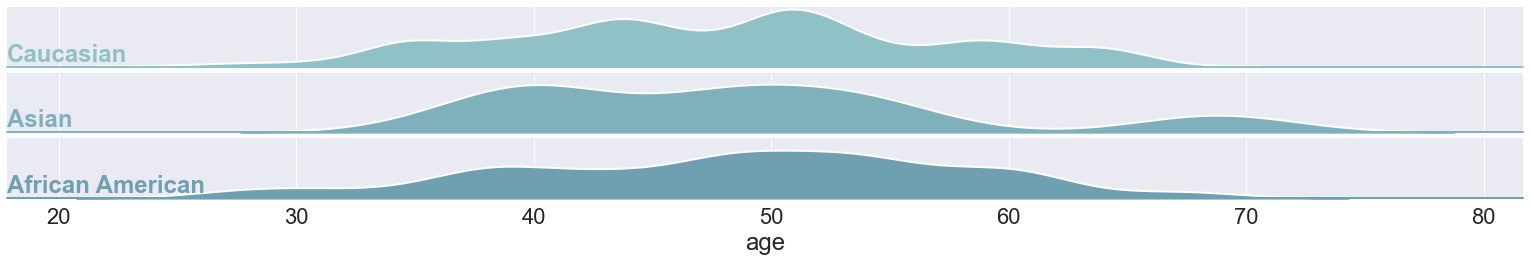

In [4]:
# Let's look at the demographics and break it down to highlight constituents. 

df = df_org.copy()
df=df.dropna()

race_to_names={
1:'Caucasian',
3:'African American',
4:'Asian',
5:'Native Hawaiian /\n Pacific Islander',
6:'American Indian /\n Alaskan Native',
50:'Multiple race'
}

import operator as op

dd = df['race_id'].value_counts()
sorted_keys, sorted_vals = zip(*sorted(dd.items(), key=op.itemgetter(1)))
dd = pd.DataFrame(dd)
dd.reset_index(inplace=True)
dd.columns = ['race', 'counts']
dd['race'].replace(race_to_names, inplace=True)
display(dd)

#Plots
fig, ax =plt.subplots(2,1)

sns.set(rc={'figure.figsize':(15, 10)}, font_scale=1, style='white') 
sns.set_context("poster")

sns.barplot(x='race', y='counts', ax=ax[0], data=dd)

ax[0].set(xlabel="Race", ylabel="Number of Participants", title="Racial / Ethnic Backgrounds")

for p in ax[0].patches:
        ax[0].annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()), ha='center', va='bottom', color= 'black')

#sns.set(rc={'figure.figsize':(15,12)})
#font_scale=4)     
ax1=sns.histplot(df['age'], color='salmon', ax=ax[1])
ax1.set(xlabel="Age (Years)");

plt.subplots_adjust(bottom=0.5)
fig.tight_layout()


df=df.loc[df['race_id'].isin([1, 3, 4])]
df['race_id'].replace({1:'Caucasian', 3:'African American', 4:'Asian'}, inplace=True)

#sns.set_context("poster")
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set(style="whitegrid")
sns.set(font_scale=2)
# Initialize the FacetGrid
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="race_id", hue="race_id", aspect=15, height=1.5, palette=pal)

# Draw the densities
g.map(sns.kdeplot, "age", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "age", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

g.map(label, "age")
# Set the subplots to overlap
g.fig.subplots_adjust(hspace=.1)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True);

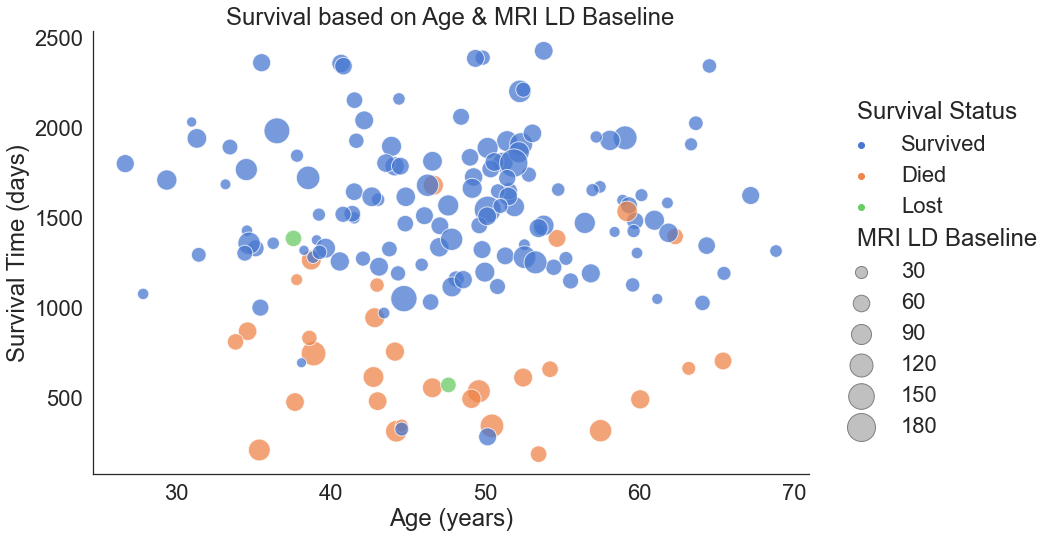

In [5]:
#To explore survival based on age and a tumor factor
df = df_org.copy()
df.dropna(inplace=True)

sns.set(rc={'figure.figsize':(1, 8)}, style="white", font_scale=2)

g = sns.relplot(x="age", y="survDtD2 (tx)", hue="sstat", size="MRI LD Baseline", 
            sizes=(100, 800), alpha=0.75, palette="muted",  
            height=8, aspect = 1.5, facet_kws={"legend_out": True}, data=df)

legend_labels = ['Survival Status', 'Survived', 'Died', 'Lost']
for i,j, in zip(g._legend.texts[0:4], legend_labels): i.set_text(j)
    
for i in g._legend.legendHandles[4:]: 
    i.set_facecolors(['silver'])
    i.set_edgecolors(['grey'])

#plt.axhline(df['survDtD2 (tx)'].mean(), linestyle = '--', color = 'g')
#plt.axvline(df['age'].mean(), linestyle = '--', color = 'y')

g.set(xlabel="Age (years)", ylabel = "Survival Time (days)", title='Survival based on Age & MRI LD Baseline')
g.tight_layout()

#display(df['survDtD2 (tx)'].describe())

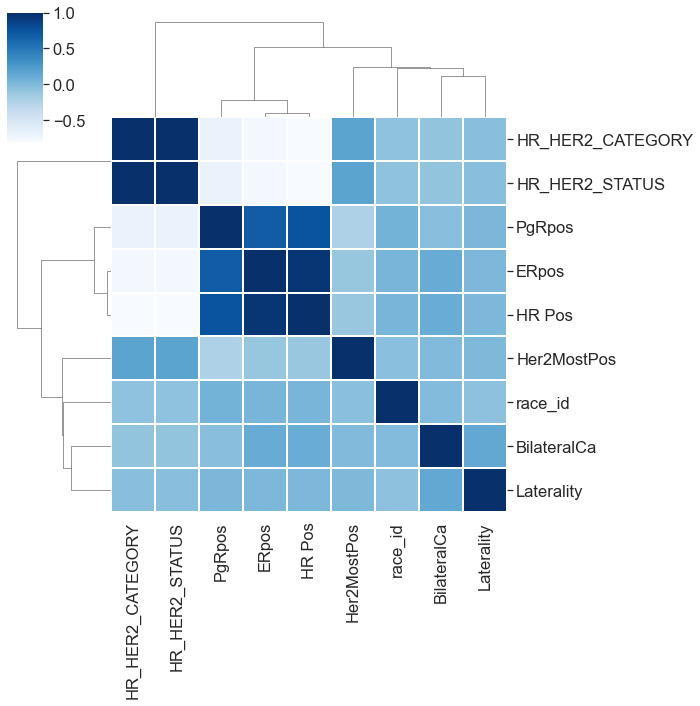

In [6]:
# Just to get a feel for clusters without too much scaling / engineering 
df = df_org.copy()
df = df.dropna()

sns.set(rc={'figure.figsize':(1, 8)}, style="white", font_scale=2)

df = df.loc[:,'race_id':'Laterality']
df = df.apply(lambda x: x.astype('float64'), axis=1) 

cmap = sns.light_palette('black', as_cmap=True)
corr_features = df.corr().sort_index()

sns.set(font_scale=1.5)
sns.clustermap(corr_features, cmap='Blues', linewidth=1, figsize=(10,10));

In [7]:
#Quick look at the correlation matrix
#TODO proper scaling

df = df_org.copy()
df.dropna(inplace=True)
df.rename(columns=short_names, inplace=True)

corr = df.loc[:, 'age':].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,age,race_id,ER+,Pg+,HR+,HR2M+,HR2C,HR2S,BCa,Lt,MRI LD Baseline,MRI LD 1-3dAC,MRI LD InterReg,MRI LD PreSurg,sstat,survDtD2 (tx),RFS,rfs_ind,PCR,RCBClass
age,1.00,-0.03,0.01,0.03,-0.01,0.07,-0.07,-0.07,-0.01,-0.05,-0.03,-0.07,-0.08,-0.00,-0.06,0.02,0.06,-0.08,-0.09,0.12
race_id,-0.03,1.00,0.03,0.06,0.03,-0.04,-0.07,-0.07,-0.01,-0.05,0.06,0.06,0.11,0.11,0.01,0.03,0.04,-0.05,0.13,-0.12
ER+,0.01,0.03,1.00,0.70,0.95,-0.10,-0.77,-0.77,0.11,0.01,-0.05,0.02,0.03,0.09,-0.20,0.22,0.21,-0.19,-0.26,0.23
Pg+,0.03,0.06,0.70,1.00,0.75,-0.22,-0.69,-0.69,-0.04,0.02,-0.02,0.05,0.09,0.17,-0.09,0.10,0.08,-0.08,-0.29,0.30
HR+,-0.01,0.03,0.95,0.75,1.00,-0.11,-0.81,-0.81,0.11,0.02,0.00,0.09,0.11,0.15,-0.14,0.15,0.14,-0.14,-0.29,0.28
HR2M+,0.07,-0.04,-0.10,-0.22,-0.11,1.00,0.18,0.18,0.00,0.01,0.09,0.10,0.03,-0.04,-0.00,0.01,-0.04,0.10,0.26,-0.31
HR2C,-0.07,-0.07,-0.77,-0.69,-0.81,0.18,1.00,1.00,-0.08,-0.03,0.04,-0.04,-0.10,-0.15,0.10,-0.12,-0.13,0.17,0.29,-0.27
HR2S,-0.07,-0.07,-0.77,-0.69,-0.81,0.18,1.00,1.00,-0.08,-0.03,0.04,-0.04,-0.10,-0.15,0.10,-0.12,-0.13,0.17,0.29,-0.27
BCa,-0.01,-0.01,0.11,-0.04,0.11,0.00,-0.08,-0.08,1.00,0.14,0.11,0.15,0.14,0.01,-0.06,0.13,0.17,-0.08,-0.08,0.01
Lt,-0.05,-0.05,0.01,0.02,0.02,0.01,-0.03,-0.03,0.14,1.00,-0.05,-0.04,-0.04,-0.05,0.09,-0.03,0.03,-0.05,0.02,-0.04


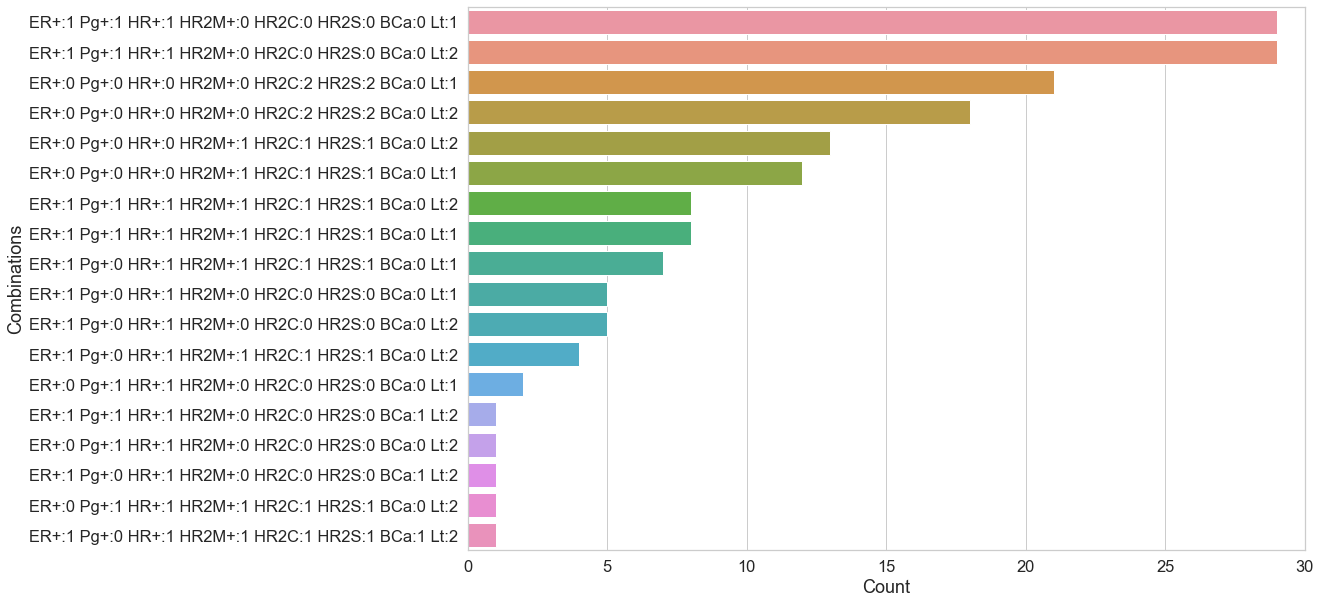

In [8]:
# Let's see what and how many 'combinations' of features are there - kinda quick 'cluster' analysis
if 'combinations' in df.columns:
    del df['combinations']

df = df.loc[:, short_names.values()]

import re
pattern = "[{}'',]"

def short_name(x):
     x = str(x.to_dict())
     x = re.sub(pattern,"", x)
     return x.replace(".0", "").replace(": ", ":")

df['combinations'] = df.apply(lambda x: short_name(x), axis=1)
#display(df['combinations'].value_counts())

df.set_index('combinations')

sns.set(rc={'figure.figsize':(15,10)}, style="whitegrid", font_scale=1.5)
#plt.rcParams['figure.dpi'] = 360

ax=sns.countplot(y=df['combinations'], order = df['combinations'].value_counts().index);
ax.set(xlabel="Count", ylabel = "Combinations", xlim=(0,30));

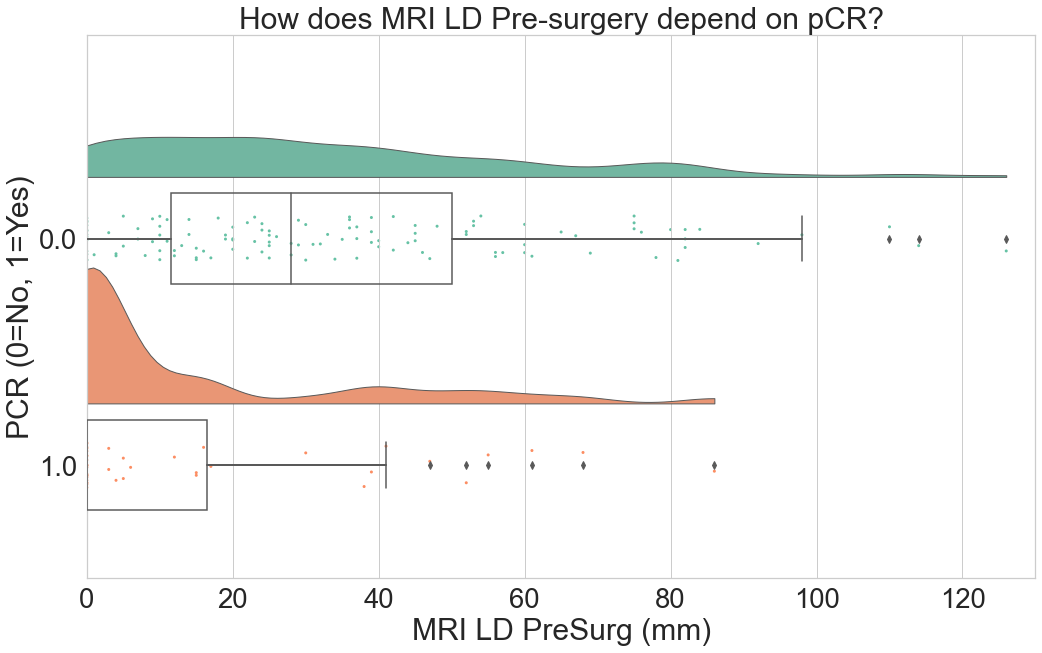

In [9]:
# How does MRI LD Pre-surgery depends on pCR? 
df = df_org.copy()
df.dropna(inplace=True)

import ptitprince as pt

sns.set(rc={'figure.figsize':(17,10)}, style="whitegrid", font_scale=2.5)

ax = pt.RainCloud(y = df['MRI LD PreSurg'], x = df['PCR'], 
                  data = df, 
                  width_viol = 1.2,
                  width_box = .4,
                  orient = 'h',
                  move = .0)

ax.set(xlabel="MRI LD PreSurg (mm)", ylabel = "PCR (0=No, 1=Yes)", xlim=(0, 130), 
       title='How does MRI LD Pre-surgery depend on pCR?')

fig.tight_layout()

0.0    123
1.0     43
Name: PCR, dtype: int64


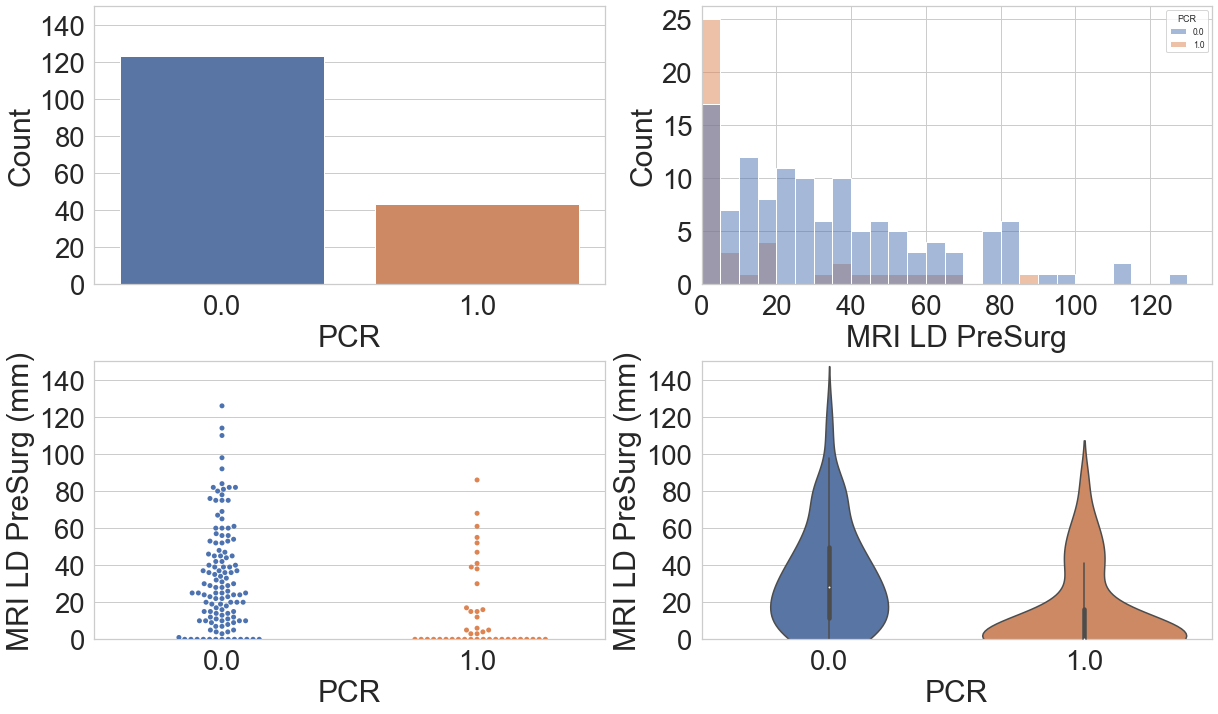

In [10]:
# How does MRI LD Pre-surgery depends on pCR? 

df = df_org.copy()
df=df.dropna()

print(df['PCR'].value_counts())

#g.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
#g.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
#g.grid(b=True, which='major', color='w', linewidth=5.0)
#g.grid(b=True, which='minor', color='w', linewidth=1)

#plt.figure(figsize=(20,10))
fig, ax =plt.subplots(2,2)

sns.set(rc={'figure.figsize':(11,8)}, style="whitegrid", font_scale=0.75)

sns.countplot(x='PCR', ax=ax[0][0], data=df).set(ylabel="Count", ylim=(0, 150));
sns.histplot(x='MRI LD PreSurg', hue='PCR', ax=ax[0][1], data=df, binwidth=5);
sns.swarmplot(x="PCR", y="MRI LD PreSurg", data=df, ax=ax[1][0], size=5).set(ylabel="MRI LD PreSurg (mm)", ylim=(0, 150)); #yticks=np.arange(10,160,10)
sns.violinplot(x="PCR", y="MRI LD PreSurg", data=df, ax=ax[1][1]).set(ylabel="MRI LD PreSurg (mm)", ylim=(0, 150));
ax[0][1].set(xlim=(0, None))
fig.tight_layout();

In [11]:
#Let's fit a regression model for PCR over MRI LD Pre-surgery
#We have a class imbalance issue - so let's fix it now

df = df_org.copy()
df.dropna(inplace=True)

# Separate majority and minority classes
df_majority = df[df.PCR==0]
df_minority = df[df.PCR==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
X = df_upsampled['MRI LD PreSurg'].to_numpy().reshape(-1,1)
y = df_upsampled['PCR']

# Display new class counts
pd.DataFrame(df_upsampled.PCR.value_counts())

,PCR
0.0,123
1.0,123


0.6567307692307691
0.11629758115842503
0.0    123
1.0    123
Name: PCR, dtype: int64


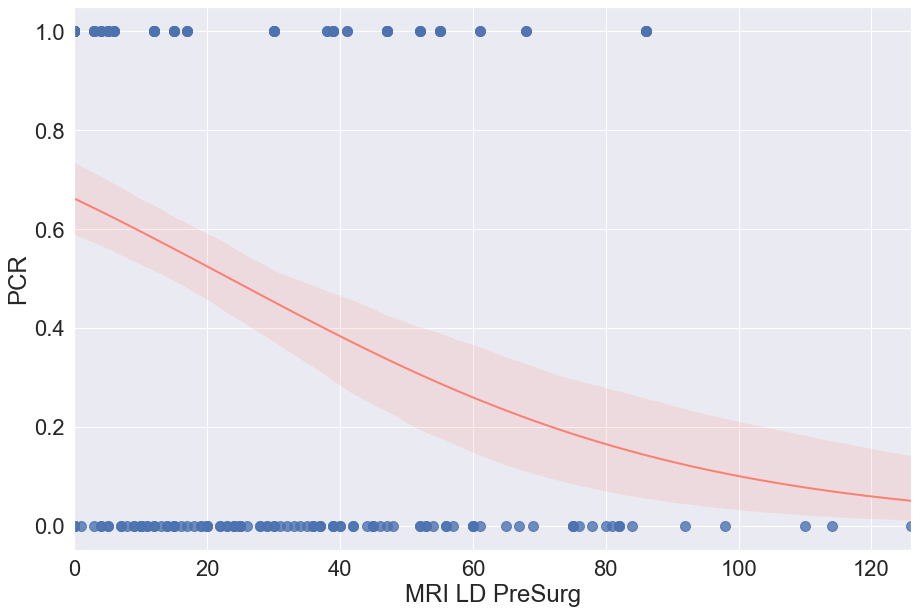

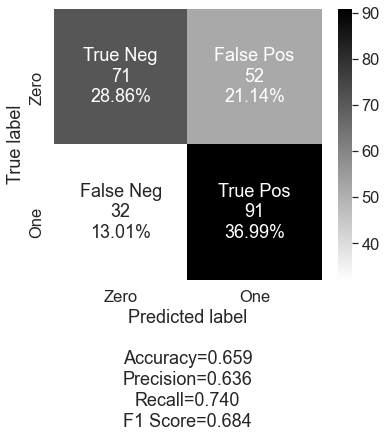

In [12]:
#Let's fit a logistic regression to PCR/MRI base. 

clf = LogisticRegressionCV(cv=20).fit(X,y)

scores = cross_val_score(clf, X, y, cv=20)
print(scores.mean())
print(scores.std())

probs = clf.predict_proba(X)[:,0]
probs = pd.DataFrame(probs)
data =df_upsampled.loc[:, ['MRI LD PreSurg', 'PCR'] ]

[clf.coef_, clf.intercept_]
print(y.value_counts())

cf_matrix = confusion_matrix(y, clf.predict(X))

sns.set(rc={'figure.figsize':(15,10)}, style="darkgrid", font_scale=2)

sns.regplot(x='MRI LD PreSurg', y='PCR', data=data, logistic=True, scatter_kws={'s':100}, line_kws={'linewidth':2, 'color':'salmon'});

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']

sns.set(rc={'figure.figsize':(6,5)}, font_scale=1.5)
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

#print(classification_report(y, clf.predict(X)) )

[0. 1.]
0.8658536585365854
0.9123537576839182


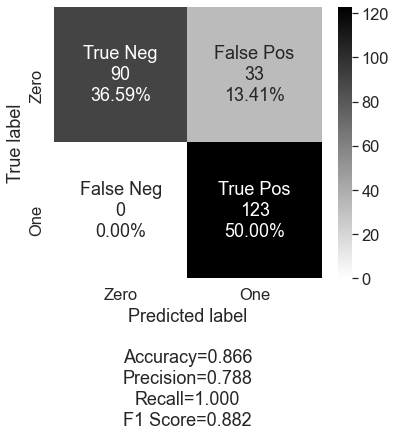

In [13]:
# Can we improve our prediction accuracy? 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
 
# Train model
clf_RFC = RandomForestClassifier()
clf_RFC.fit(X, y)
 
pred_y_RFC = clf_RFC.predict(X)
 
print(np.unique( pred_y_RFC ) ) 
print(accuracy_score(y, pred_y_RFC) )
 
prob_y_RFC = clf_RFC.predict_proba(X)
prob_y_RFC = [p[1] for p in prob_y_RFC]
print(roc_auc_score(y, prob_y_RFC) )

cf_matrix = confusion_matrix(y, clf_RFC.predict(X))

sns.set(rc={'figure.figsize':(6,5)}, font_scale=1.5)

make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')


0.8809240531429704


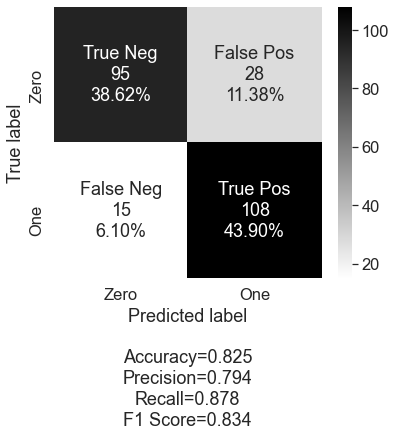

In [14]:
#Let's bring a gun to a knife fight to see if we could get even better accuracy with no tuning! 
from xgboost import XGBClassifier

clf_xgb = XGBClassifier()
clf_xgb.fit(X,y)
confusion = confusion_matrix(y, clf_xgb.predict(X))

prob_y = clf_xgb.predict_proba(X)
prob_y = [p[1] for p in prob_y]
print( roc_auc_score(y, prob_y))

sns.set(rc={'figure.figsize':(6,5)}, font_scale=1.5)

make_confusion_matrix(confusion, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

In [15]:
#Breakdown survival figures to understand

df = df_org.loc[:,['sstat', 'PCR']].copy()

dict1 = {0:'No PCR', 1:'PCR'} 
dict2 = {7:'Alive', 8:'Dead', 9:'Lost'} 

df.loc[df['PCR' ].isnull(),'PCR']='No Surgery'
df['PCR'].replace(dict1, inplace=True)

df['sstat'].replace(dict2, inplace=True)

display(pd.DataFrame(df.sstat.value_counts()))
display(pd.DataFrame(df.PCR.value_counts()))

display(pd.DataFrame(df.groupby('PCR')['sstat'].value_counts()))

,sstat
Alive,176
Dead,40
Lost,5


,PCR
No PCR,157
PCR,58
No Surgery,6


sstat
PCR        sstat       
No PCR     Alive    121
           Dead      34
           Lost       2
No Surgery Alive      2
           Dead       2
           Lost       2
PCR        Alive     53
           Dead       4
           Lost       1

In [16]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

eee = np.arange(25,75,5)
tt = pd.cut(predictors['age'].copy(),eee)
tt.value_counts()

predictors['race_id'].value_counts()

1     165
3      42
4       9
0       2
50      2
5       1
Name: race_id, dtype: int64

In [17]:
df = df_org.loc[:,['PCR', 'sstat', 'survDtD2 (tx)']].copy()

df['sstat'].replace({7:1, 8:0}, inplace=True)

#Assuming that we are interested in non-life / PCR related events
df = df[df.sstat!=9] #Lost
df.dropna()


display(pd.DataFrame(df.sstat.value_counts()))
display(pd.DataFrame(df.PCR.value_counts()))
display(pd.DataFrame(df.groupby('PCR')['sstat'].value_counts()))

,sstat
1,176
0,40


,PCR
0.0,155
1.0,57


sstat
PCR sstat       
0.0 1        121
    0         34
1.0 1         53
    0          4

## KM Model
#### $$\underbrace{h(t | x)}_{\text{hazard}} = \overbrace{b_0(t)}^{\text{baseline hazard}} \underbrace{\exp \overbrace{\left(\sum_{i=1}^n b_i (x_i - \overline{x_i})\right)}^{\text{log-partial hazard}}}_ {\text{partial hazard}}$$

1    176
0     40
Name: sstat, dtype: int64

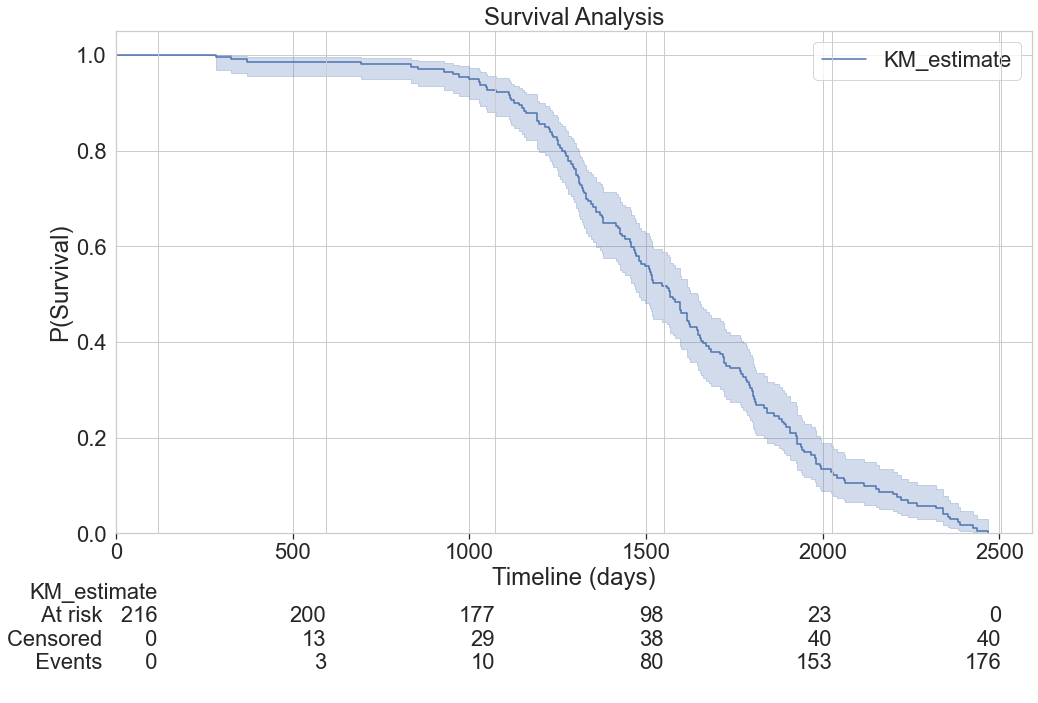

In [18]:
#A bit out of my depth here but let's fit a Kaplan model. 

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times

df = df_org.copy()
df = df[df.sstat!=9] #Get rid of Lost data points
df.loc[df['sstat']==7, 'sstat']=1 #Alive
df.loc[df['sstat']==8, 'sstat']=0 #Dead
display(df['sstat'].value_counts())

kmf = KaplanMeierFitter()

T = df["survDtD2 (tx)"]
E = df["sstat"]

sns.set(rc={'figure.figsize':(15,10)}, style="whitegrid", font_scale=2)

ax = plt.axes()

kmf.fit(T, event_observed=E)
kmf.plot_survival_function(at_risk_counts=True)
median_ci = median_survival_times(kmf.confidence_interval_)
#print(kmf.median_survival_time_, median_ci)
ax.set(ylabel="P(Survival)", ylim=(0, 1.05), xlabel="Timeline (days)", xlim=(0, None), title='Survival Analysis');

1516.0      pCR_lower_0.95  pCR_upper_0.95
0.5          1357.0          1646.0


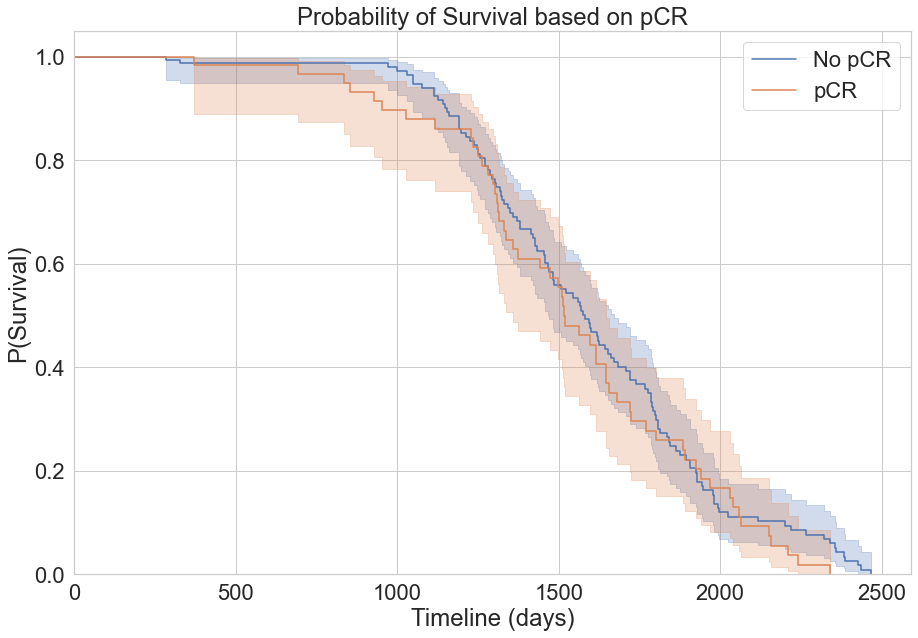

In [19]:
#Let's break down survial based on PCR

pcr_no = (df['PCR']==0)


ax = plt.axes()
sns.set(rc={'figure.figsize':(15,10)}, style="whitegrid", font_scale=2)

kmf.fit(T[pcr_no], event_observed=E[pcr_no], label="No pCR")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~pcr_no], event_observed=E[~pcr_no], label="pCR")
kmf.plot_survival_function(ax=ax)

ax.set(ylabel="P(Survival)", ylim=(0, 1.05), xlabel="Timeline (days)", xlim=(0, None), 
       title='Probability of Survival based on pCR');

median_ci = median_survival_times(kmf.confidence_interval_)
print(kmf.median_survival_time_, median_ci)

<lifelines.CoxPHFitter: fitted with 166 total observations, 0 right-censored observations>
             duration col = 'survDtD2 (tx)'
                event col = 'sstat'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 166
number of events observed = 166
   partial log-likelihood = -677.59
         time fit was run = 2021-01-19 17:30:39 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
age              -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
race_id           0.00       1.00       0.02            -0.04             0.05                 0.96                 1.05
ER+              -0.56       0.57       0.36            -1.27             0.14                 0.28                 1.15
Pg+              -0.09       0.91       0.23            -0.54             0.36                 0.58                 1.43
HR+               0.21       1.23       0.37            -0.52             0.93                 0.60                 2.55
HR2M+             0.21       1.24       0.18            -0.13             0.56                 0.88                 1.75
HR2C             -0.02       0.98       0.23            -0.47             0.44                 0.62                 1.55
HR2S             -0.02       0.98       0.23            -0.47             0.44                 0.62                 1.55
BCa              -0.64       0.53       0.56            -1.75             0.47                 0.17                 1.59
Lt                0.13       1.14       0.15            -0.17             0.43                 0.84                 1.54
MRI LD Baseline  -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
MRI LD 1-3dAC    -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
MRI LD InterReg   0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
MRI LD PreSurg   -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
PCR              -0.11       0.89       0.28            -0.67             0.44                 0.51                 1.56
RCBClass          0.19       1.21       0.12            -0.05             0.43                 0.95                 1.54

                    z    p   -log2(p)
covariate                            
age             -0.18 0.86       0.22
race_id          0.15 0.88       0.18
ER+             -1.57 0.12       3.10
Pg+             -0.40 0.69       0.53
HR+              0.56 0.57       0.80
HR2M+            1.21 0.22       2.15
HR2C            -0.07 0.94       0.09
HR2S            -0.07 0.94       0.09
BCa             -1.13 0.26       1.96
Lt               0.85 0.40       1.34
MRI LD Baseline -0.82 0.41       1.28
MRI LD 1-3dAC   -0.12 0.90       0.15
MRI LD InterReg  1.24 0.22       2.22
MRI LD PreSurg  -1.12 0.26       1.92
PCR             -0.40 0.69       0.54
RCBClass         1.58 0.11       3.12
---
Concordance = 0.63
Partial AIC = 1387.19
log-likelihood ratio test = 16.94 on 16 df
-log2(p) of ll-ratio test = 1.36

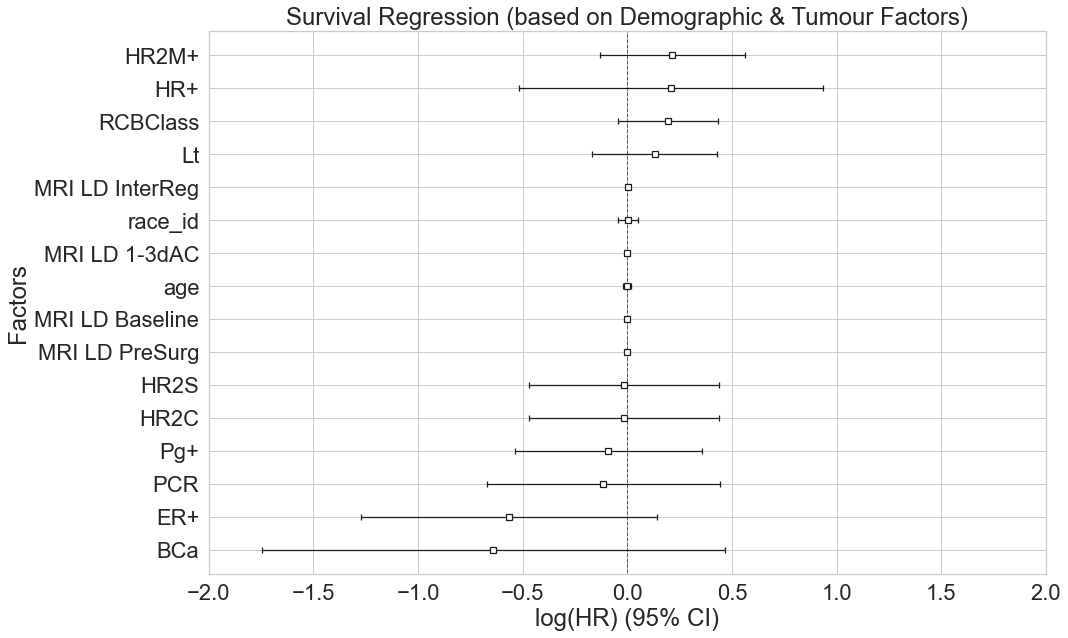

In [20]:
from lifelines import CoxPHFitter

df = df_org.copy()
df.dropna(inplace=True)
df.drop(['SUBJECTID', 'RFS', 'rfs_ind'], axis=1, inplace=True)

df.rename(columns=short_names, inplace=True)

ax = plt.axes()
sns.set(rc={'figure.figsize':(15,10)}, style="whitegrid", font_scale=2)

cph = CoxPHFitter(penalizer=0.1)
cph.fit(df, duration_col='survDtD2 (tx)', event_col='sstat')

cph.print_summary()

cph.plot()

ax.set(ylabel="Factors", xlim=(-2,2) ,title='Survival Regression (based on Demographic & Tumour Factors)');